In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# Fetch Data signals
## Import Data

In [2]:
HSBC_data = pd.read_csv("HSBA.L.csv")
HSBC_data['Date'] = pd.to_datetime(HSBC_data['Date'])  
HSBC_data.set_index(["Date"],inplace=True)

In [3]:
print(HSBC_data.isnull().any())
print("\n",f"Shape of dataset: {HSBC_data.shape}")

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

 Shape of dataset: (3066, 6)


## Signal Creation

In [4]:
import talib
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
# https://www.alpharithms.com/autocorrelation-time-series-python-432909/

In [5]:
signals = pd.DataFrame() # Different signals that could be relevant

# user-defined
#signals['Return1'] = (HSBC_data["Close"]-HSBC_data["Close"].shift(periods=1))/HSBC_data["Close"].shift(periods=1)
#signals['Return5'] = (HSBC_data["Close"]-HSBC_data["Close"].shift(periods=5))/HSBC_data["Close"].shift(periods=5)
#signals['Avg5'] = HSBC_data.Close.rolling(5).mean()
#signals['Avg10'] = HSBC_data.Close.rolling(10).mean()
#signals['Avg30'] = HSBC_data.Close.rolling(30).mean()
#signals['Std10'] = HSBC_data.Close.rolling(10).std()
#signals['Std30'] = HSBC_data.Close.rolling(30).std()
#signals["AMP"]=HSBC_data.Close-HSBC_data.Open # rather similar to ROC
#signals["AMPabs"]=np.abs(HSBC_data.Close-HSBC_data.Open)
signals["VOL"]=HSBC_data.Volume

# Talib
signals["EMA"]=talib.EMA(HSBC_data.Close)  # Exponential Moving Average
signals["RSI"]=talib.RSI(HSBC_data.Close)  # Relative Strength Index
signals["ROC10"]=talib.ROC(HSBC_data.Close)  #  Rate Of Change 10d
signals["ROC1"]=talib.ROC(HSBC_data.Close,timeperiod=1)  # Rate of Change 1d
signals["ROC10abs"]=np.abs(talib.ROC(HSBC_data.Close,timeperiod=10))  # Abs Rate Of Chaneg 1d
signals["MOM"]=talib.MOM(HSBC_data.Close,timeperiod=10) # this is the same as ROC, but not /prev
signals["NATR"]=talib.NATR(close=HSBC_data.Close, \
                         high=HSBC_data.High, low=HSBC_data.Low,timeperiod=5) # Normalized Average True Range
signals["BBANDup"],_,signals["BBANDdwn"]= talib.BBANDS(HSBC_data.Close,timeperiod=5)  # Bollinger Bands

In [6]:
# The selected signals for our model:
features = signals[["ROC10abs","VOL","RSI","ROC10","NATR"]].iloc[20:]

## Plotting signals  
Plot some of the signals:

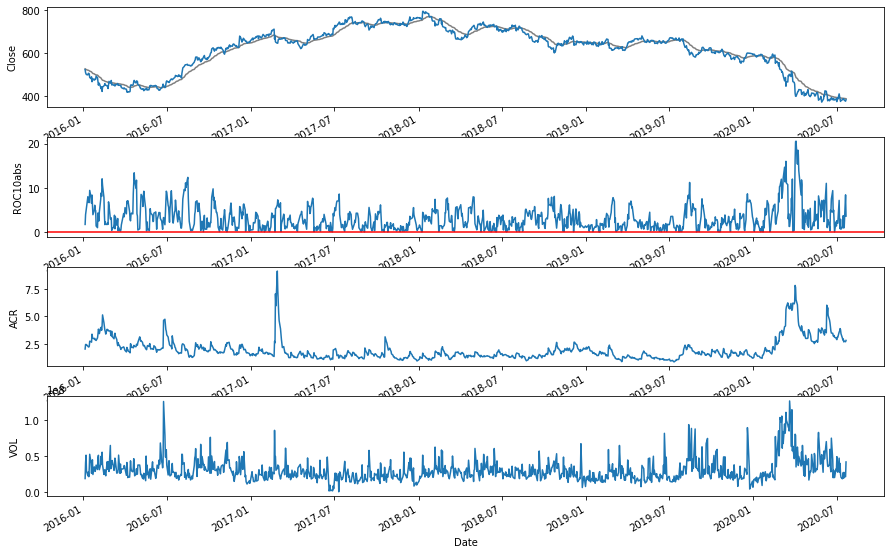

In [7]:
time_range=range(-1550,-400)
fig, ax = plt.subplots(4,1,figsize=(15,10))
plt.subplots_adjust(hspace=0.3)

signals["EMA"].iloc[time_range].plot(ax=ax[0],xlabel=None,color='gray')
HSBC_data.Close.iloc[time_range].plot(ax=ax[0],ylabel="Close",xlabel=None)

signals["ROC10abs"].iloc[time_range].plot(ax=ax[1],ylabel="ROC10abs")
ax[1].axhline(y = 0,c='r')

signals["NATR"].iloc[time_range].plot(ax=ax[2],ylabel="ACR");
signals["VOL"].iloc[time_range].plot(ax=ax[3],ylabel="VOL");

#signals["RSI"].iloc[-550:-400].plot(ax=ax[-1],ylabel="RSI")
#plt.axhline(y = 70,c='r')
#plt.axhline(y = 30,c='r');

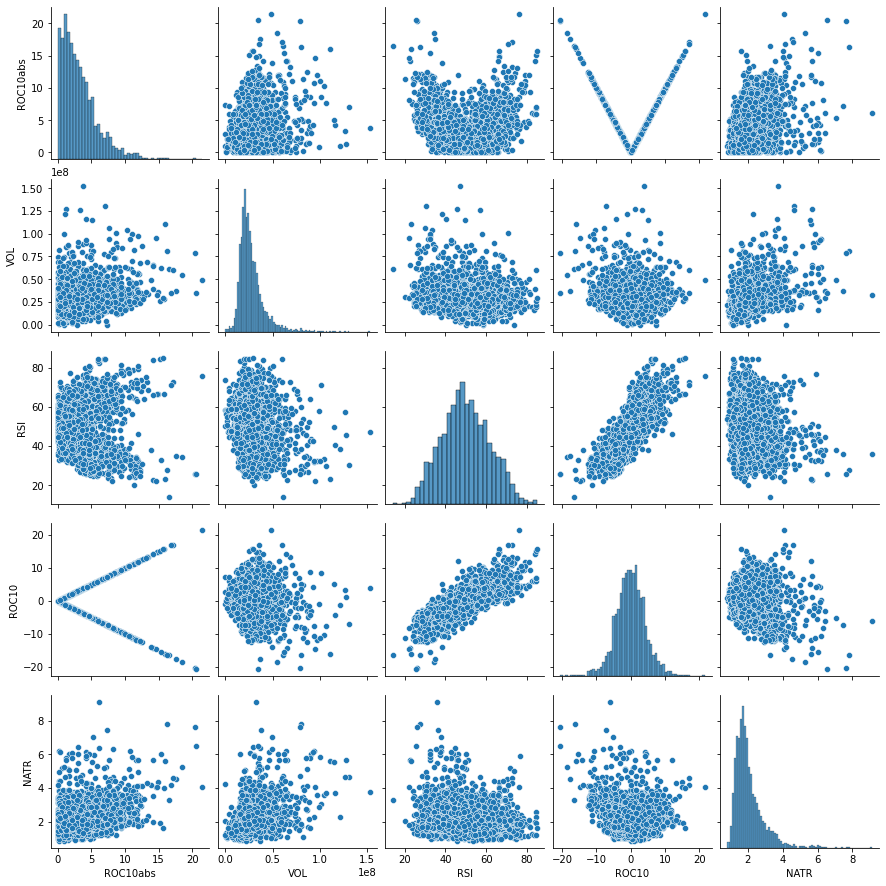

In [8]:
# Correlation plots of the features
sns.pairplot(data=features);

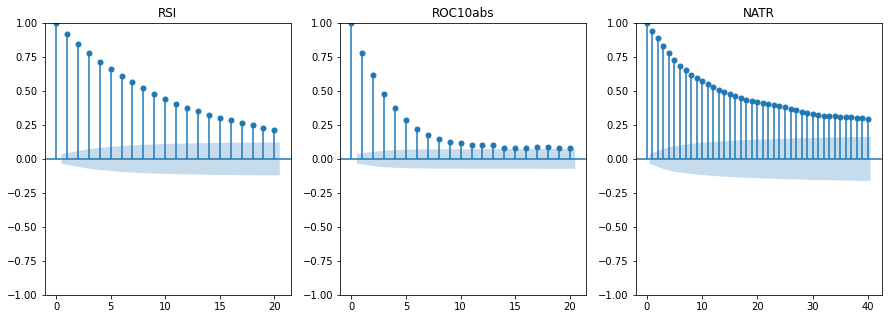

In [9]:
# Auto correlations

fig, ax = plt.subplots(1,3,figsize=(15,5))
plot_acf(signals["RSI"].dropna(),lags=20,title="RSI",ax=ax[0]);
plot_acf(signals["ROC10abs"].dropna(),lags=20,title="ROC10abs",ax=ax[1]);
plot_acf(signals["NATR"].dropna(),lags=40,title="NATR",ax=ax[2]);

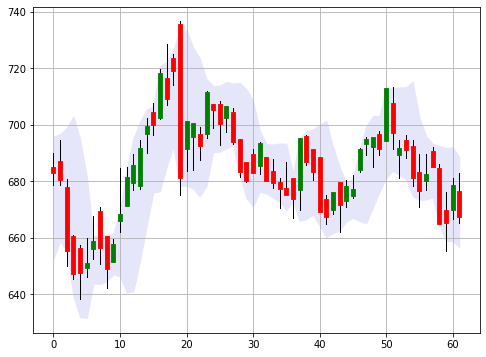

In [10]:
def candlestick_plot(df):
    """ 
    function takes DataFrame with "Open", "Close", "High", "Low" columns.
    Indexed either by timestamp or int index. Returns axes object.
    """
    fig, ax = plt.subplots(figsize=(8,6))
    ax.grid(True)
    candle_width = 300/df.shape[0]
    for date in df.index:
        
        # Plot Highest-Lowest
        plt.plot([date,date],[df.loc[date,"High"],df.loc[date,"Low"]],\
                     linewidth=1,color="k")
        
        # Plot candles
        if df.loc[date,"Close"] <= df.loc[date,"Open"]: # if down plor red
            plt.plot([date,date],[df.loc[date,"Open"],df.loc[date,"Close"]],\
                     linewidth=candle_width,color="r")
        else:  #if up print green
            plt.plot([date,date],[df.loc[date,"Open"],df.loc[date,"Close"]],\
                     linewidth=candle_width,color="g")
    return(ax)
    
#candlestick_plot(HSBC_data.loc["2010-2-1":"2010-05-1"].reset_index());

# Bolinger bands plot
mask=(HSBC_data.index>pd.to_datetime("2010-02-1"))&(HSBC_data.index<pd.to_datetime("2010-05-1"))

ax = candlestick_plot(HSBC_data.loc[mask].reset_index())

plt.fill_between(HSBC_data.loc[mask].reset_index().index,signals.loc[mask].BBANDdwn,
                 signals.loc[mask].BBANDup,color='lavender');

# Data Pre-processing


In [11]:
from sklearn.preprocessing import MinMaxScaler

In [53]:
#  parameters of the training and test data

target = "ROC10"

train_start_date = pd.to_datetime("2011-01-01")
train_test_split_date = pd.to_datetime("2019-01-01")
test_end_date = pd.to_datetime("2019-12-31")

sample_size = 10 

In [54]:
train_dates = [date for date in features.index if train_start_date <= date <= train_test_split_date]
test_dates = [date for date in features.index if train_test_split_date < date <= test_end_date]

# scale features
scaler = MinMaxScaler()
train_features = pd.DataFrame(
    scaler.fit_transform(features.loc[:train_test_split_date]),
    columns=features.columns)
train_features["Date"] = features.loc[:train_test_split_date].index
train_features.set_index("Date",inplace=True)

# test features are scaled separetely in order to avoid look-ahead bias
test_features = pd.DataFrame(scaler.fit_transform(features),columns=features.columns)
test_features["Date"] = features.index
test_features.set_index("Date",inplace=True)

# get train and test labels
y_train = signals.loc[train_dates][target].values
y_test = signals.loc[test_dates][target].values

# get scaled train and test feature tensors. Note that they are shifted one dat
x_train = np.array([train_features.loc[:date].iloc[-(sample_size+1):-1].values for date in train_dates ])
x_test = np.array([test_features.loc[:date].iloc[-(sample_size+1):-1].values for date in test_dates ])

# check dimensions of feature tensors
x_train.shape == (len(train_dates), sample_size, features.shape[1])
x_test.shape == (len(test_dates), sample_size, features.shape[1])

True

# Build Model

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [57]:
tf.keras.backend.clear_session()

In [58]:
input_layer = Input(shape=(sample_size,features.shape[1]))
layer_1 = LSTM(20,return_sequences=True)(input_layer)
layer_2 = Dropout(0.1)(layer_1)
layer_3 = LSTM(30,return_sequences=True)(layer_2)
layer_4 = Dropout(0.1)(layer_3)
layer_45= LSTM(10)(layer_4)
layer_5 = Dense(10, activation="relu")(layer_45)
output_layer = Dense(1,activation="linear")(layer_5)

LSTM_model = Model(inputs=input_layer, outputs=output_layer)
adam = Adam(learning_rate=0.002)
LSTM_model.compile(optimizer=adam, loss="mse")

In [59]:
LSTM_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 5)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 20)            2080      
_________________________________________________________________
dropout (Dropout)            (None, 10, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            6120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1640      
_________________________________________________________________
dense (Dense)                (None, 10)                110   

In [60]:
history = LSTM_model.fit(x_train,y_train, epochs=180,validation_data=(x_test,y_test))

Epoch 1/180
64/64 [==============================] - 10s 38ms/step - loss: 14.9401 - val_loss: 9.4925
Epoch 2/180
64/64 [==============================] - 1s 17ms/step - loss: 10.0200 - val_loss: 4.5270
Epoch 3/180
64/64 [==============================] - 1s 18ms/step - loss: 6.6480 - val_loss: 3.9211
Epoch 4/180
64/64 [==============================] - 1s 18ms/step - loss: 5.7868 - val_loss: 3.6157
Epoch 5/180
64/64 [==============================] - 2s 24ms/step - loss: 5.7014 - val_loss: 3.3935
Epoch 6/180
64/64 [==============================] - 1s 18ms/step - loss: 5.0400 - val_loss: 4.7707
Epoch 7/180
64/64 [==============================] - 1s 17ms/step - loss: 4.8492 - val_loss: 3.1411
Epoch 8/180
64/64 [==============================] - 1s 17ms/step - loss: 4.5740 - val_loss: 2.8407
Epoch 9/180
64/64 [==============================] - 1s 20ms/step - loss: 4.2835 - val_loss: 2.7796
Epoch 10/180
64/64 [==============================] - 1s 18ms/step - loss: 4.0823 - val_loss: 2.6

64/64 [==============================] - 1s 19ms/step - loss: 2.4297 - val_loss: 1.6717
Epoch 83/180
64/64 [==============================] - 1s 20ms/step - loss: 2.3282 - val_loss: 1.6719
Epoch 84/180
64/64 [==============================] - 1s 18ms/step - loss: 2.2911 - val_loss: 1.5273
Epoch 85/180
64/64 [==============================] - 1s 18ms/step - loss: 2.3812 - val_loss: 1.5684
Epoch 86/180
64/64 [==============================] - 1s 17ms/step - loss: 2.2916 - val_loss: 1.8322
Epoch 87/180
64/64 [==============================] - 1s 17ms/step - loss: 2.3699 - val_loss: 1.6374
Epoch 88/180
64/64 [==============================] - 1s 16ms/step - loss: 2.2542 - val_loss: 1.6074
Epoch 89/180
64/64 [==============================] - 1s 17ms/step - loss: 2.2564 - val_loss: 1.6606
Epoch 90/180
64/64 [==============================] - 1s 17ms/step - loss: 2.2716 - val_loss: 1.5884
Epoch 91/180
64/64 [==============================] - 1s 17ms/step - loss: 2.3144 - val_loss: 1.6965
Epo

64/64 [==============================] - 1s 17ms/step - loss: 1.8475 - val_loss: 1.6380
Epoch 163/180
64/64 [==============================] - 1s 17ms/step - loss: 1.9147 - val_loss: 1.5474
Epoch 164/180
64/64 [==============================] - 1s 16ms/step - loss: 1.8741 - val_loss: 1.7775
Epoch 165/180
64/64 [==============================] - 1s 17ms/step - loss: 1.9273 - val_loss: 1.6558
Epoch 166/180
64/64 [==============================] - 1s 17ms/step - loss: 1.8956 - val_loss: 1.6031
Epoch 167/180
64/64 [==============================] - 1s 16ms/step - loss: 1.9621 - val_loss: 1.4742
Epoch 168/180
64/64 [==============================] - 1s 17ms/step - loss: 1.9019 - val_loss: 1.7355
Epoch 169/180
64/64 [==============================] - 1s 17ms/step - loss: 1.8641 - val_loss: 1.6138
Epoch 170/180
64/64 [==============================] - 1s 17ms/step - loss: 1.8294 - val_loss: 1.5146
Epoch 171/180
64/64 [==============================] - 1s 16ms/step - loss: 1.8974 - val_loss: 1

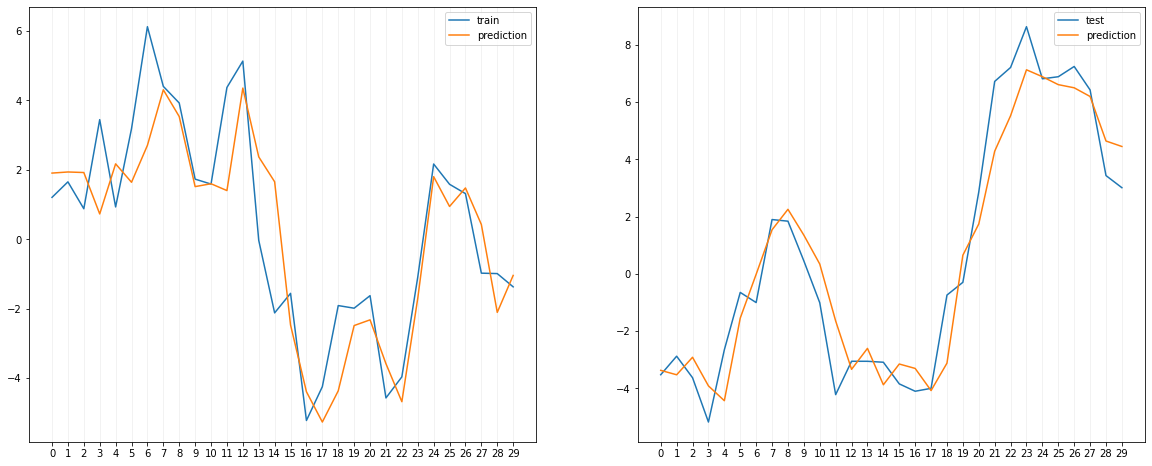

In [61]:
y_test_pred = LSTM_model.predict(x_test)
y_train_pred = LSTM_model.predict(x_train)


fig, ax = plt.subplots(1,2,figsize=(20,8))
pts=30;
ax[1].plot(y_test[-pts:])
ax[1].plot(y_test_pred[-pts:])
ax[1].legend(["test","prediction"]);
ax[1].set_xticks(range(pts))
ax[1].grid(axis = "x",alpha=0.2)

ax[0].plot(y_train[-pts:])
ax[0].plot(y_train_pred[-pts:]);
ax[0].legend(["train","prediction"]);
ax[0].set_xticks(range(pts))
ax[0].grid(axis = "x",alpha=0.2)

/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


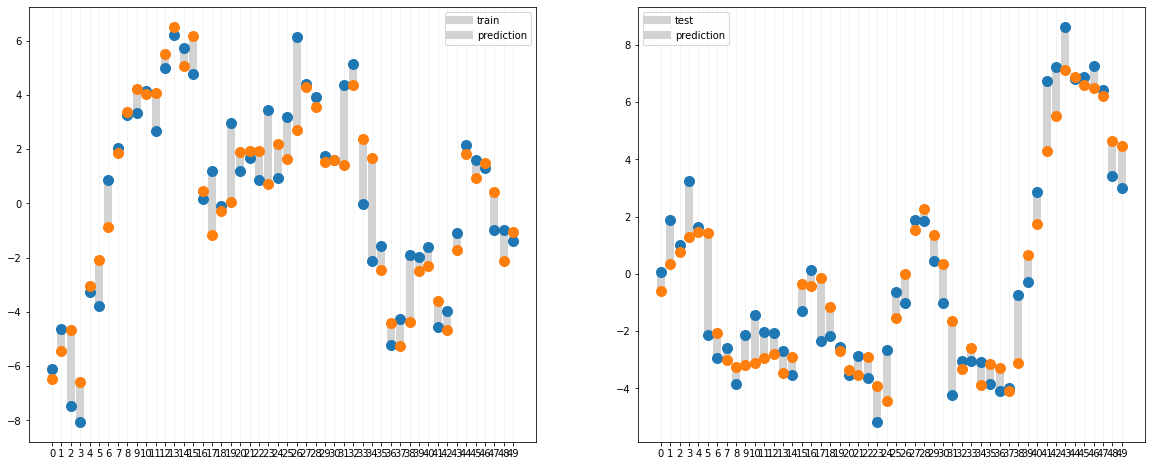

In [62]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
pts=50;


for i in range(1,pts+1):
    ax[1].plot([pts-i,pts-i],[y_test[-i],y_test_pred[-i]],color="lightgray",linewidth=8)
ax[1].plot(y_test[-pts:],".",markersize=20)
ax[1].plot(y_test_pred[-pts:],".",markersize=20)

ax[1].legend(["test","prediction"]);
ax[1].set_xticks(range(pts))
ax[1].grid(axis = "x",alpha=0.2)

for i in range(1,pts+1):
    ax[0].plot([pts-i,pts-i],[y_train[-i],y_train_pred[-i]],color="lightgray",linewidth=8)
ax[0].plot(y_train[-pts:],".",markersize=20)
ax[0].plot(y_train_pred[-pts:],".",markersize=20)
ax[0].legend(["train","prediction"]);
ax[0].set_xticks(range(pts))
ax[0].grid(axis = "x",alpha=0.2)

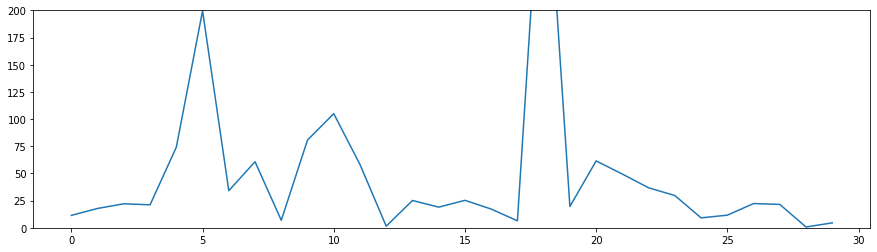

In [413]:
pcerror=np.transpose(abs((y_test[-pts:]-np.transpose(y_test_pred[-pts:]))/y_test[-pts:]))*100
fig,ax=plt.subplots(figsize=(15,4))
ax.plot(pcerror);
ax.set_ylim([0, 200]);

## Silly model comparison
We would like to compare this to the "silly model" that just copies the price of the previous day.

Copying the previous day you get a mse of 3.46 in the train set
Copying the previous day you get a mse of 2.36 in the test set


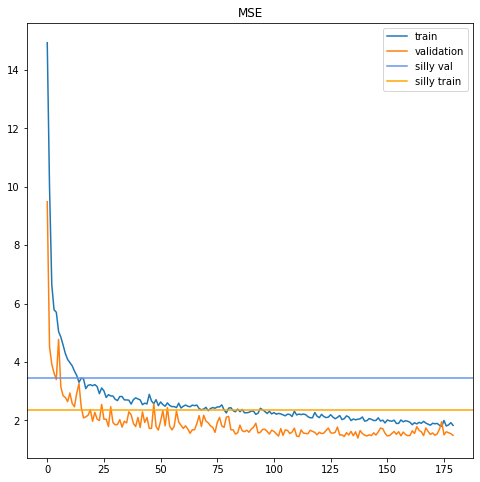

In [63]:
silly_train_loss = ((y_train[1:]-y_train[:-1])**2).mean()
silly_test_loss = ((y_test[1:]-y_test[:-1])**2).mean()
print(f"Copying the previous day you get a mse of {silly_train_loss:.3} in the train set")
print(f"Copying the previous day you get a mse of {silly_test_loss:.3} in the test set")

fig,ax = plt.subplots(figsize=(8,8))
history_df = pd.DataFrame(data=history.history)
history_df.plot(y=["loss","val_loss"],title="MSE",ax=ax)
ax.axhline(silly_train_loss,color = "cornflowerblue")
ax.axhline(silly_test_loss,color = "orange")

plt.legend(["train","validation","silly val","silly train"]);